## Imports

In [ ]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from models import utils, arx, hammerstein

In [2]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

## Extracting Data


In [3]:
data1 = utils.read_mat("/home/matthias/WS_all/dbm/raw/ex3_handout/ex3_system1_data.mat")
data2 = utils.read_mat("/home/matthias/WS_all/dbm/raw/ex3_handout/ex3_system2_data.mat")

display(data1.keys())
display(data2.keys())

dict_keys(['None', 'README', 't1', 't2', 'u1', 'u2', 'y1', 'y2'])

dict_keys(['README', 't1', 't2', 't3', 'u1', 'u2', 'u3', 'y1', 'y2', 'y3'])

In [ ]:
# Data
t = jnp.array(data2.t1)
y = jnp.array(data2.y1)
u = jnp.array(data2.u1)


t2 = jnp.array(data2.t2)
y2 = jnp.array(data2.y2)
u2 = jnp.array(data2.u2)

t3 = jnp.array(data2.t3)
y3 = jnp.array(data2.y3)
u3 = jnp.array(data2.u3)

## Plot Data


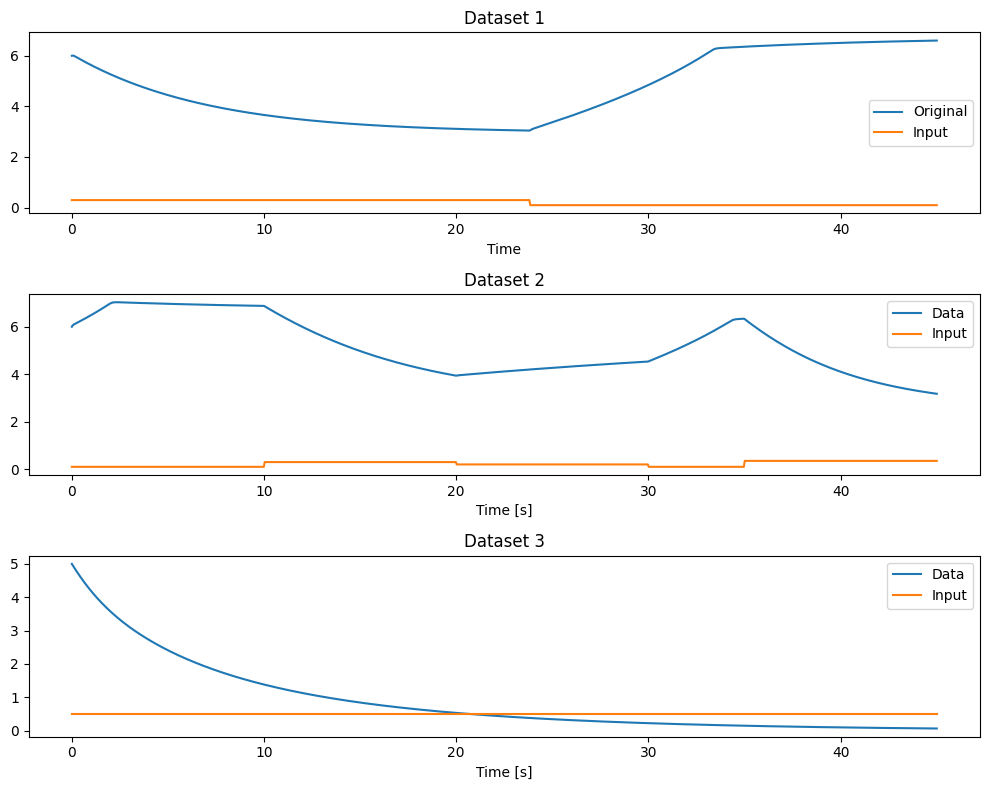

In [5]:
fig, ax = plt.subplots(3,1,figsize=(10, 8))

ax[0].plot(t, y,label='Original')
ax[0].plot(t, u, label='Input')
ax[0].legend()
ax[0].set_xlabel('Time')
ax[0].set_title('Dataset 1')

ax[1].plot(t2,y2, label='Data')
ax[1].plot(t2, u2, label='Input')
ax[1].legend()
ax[1].set_xlabel('Time [s]')
ax[1].set_title('Dataset 2')

ax[2].plot(t3,y3, label='Data')
ax[2].plot(t3, u3, label='Input')
ax[2].legend()
ax[2].set_xlabel('Time [s]')
ax[2].set_title('Dataset 3')
plt.tight_layout()
plt.show()

## Create Model


In [ ]:
na_range = jnp.array([3,6])
nb_range = jnp.array([3,6])
order_ = jnp.array([2,7])
num_polys = jnp.array([1,3])
scalers_poly = jnp.array([0.2,0.8])

y_new = jnp.concatenate([y,y3])
u_new = jnp.concatenate([u,u3])


p_hat,loss, func, order, na,nb = hammerstein.optimize(y_new,u_new,(3,4),(4,5),(5,6),(1,3),(0.25,0.7))

Total parameters: 170
Progress: 59.41 %
Estimated optimization time left: 25.45s
Current iteration time: 0.36s


In [19]:
print("Loss", loss)
print("Func", func)
print("Order", order)
print("NA", na, " NB", nb)

Loss 0.17133136
Func functools.partial(<PjitFunction of <function _polynomial at 0x7b9d09fef420>>, array=Array([0.7], dtype=float32))
Order 6
NA 3  NB 4


## Predict 

In [ ]:
y1_pred = hammerstein.simulate(y[:na], u, na,nb, order, func, p_hat)
y2_pred = hammerstein.simulate(y2[:na], u2, na, nb, order, func, p_hat)
y3_pred = hammerstein.simulate(y3[:na], u3, na, nb, order, func, p_hat)


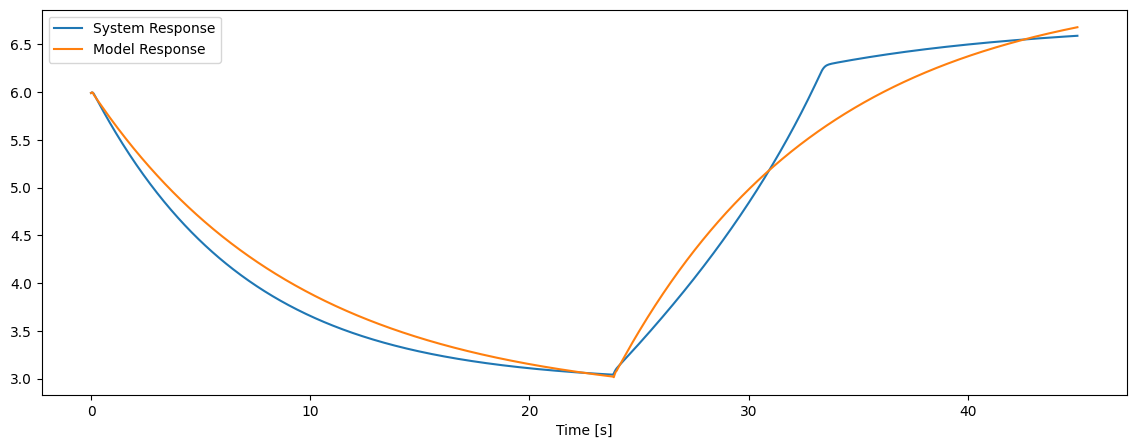

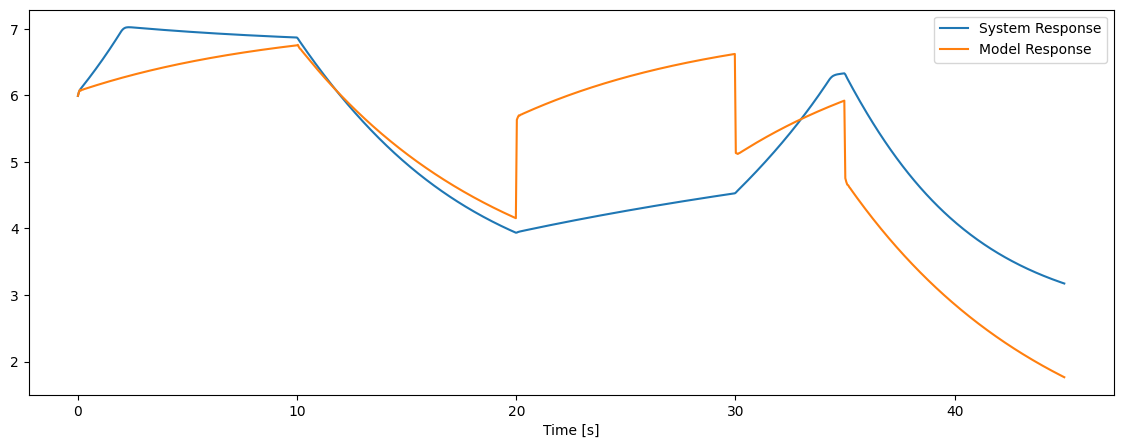

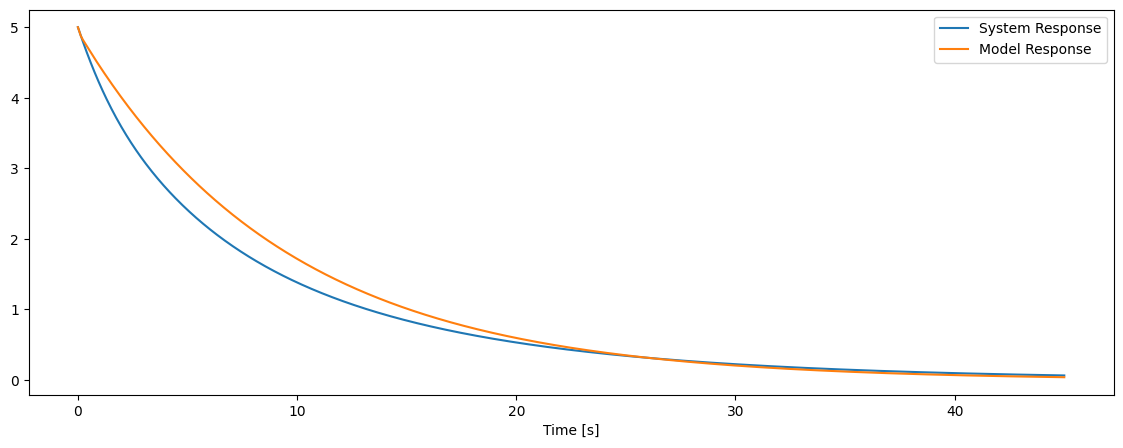

In [23]:
plt.figure(figsize=(14, 5))
plt.plot(t,y, label="System Response")
plt.xlabel("Time [s]")
plt.plot(t, y1_pred,label="Model Response")
plt.legend()
plt.show()

plt.figure(figsize=(14, 5))
plt.plot(t2,y2, label="System Response")
plt.xlabel("Time [s]")
plt.plot(t2, y2_pred,label="Model Response")
plt.legend()
plt.show()

plt.figure(figsize=(14, 5))
plt.plot(t3,y3, label="System Response")
plt.xlabel("Time [s]")
plt.plot(t3, y3_pred,label="Model Response")
plt.legend()
plt.show()
